In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
import Augmentor
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
from IPython.display import FileLink

In [2]:
class SeedlingDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        return image, int(labels)

In [3]:
data_dir = '/home/tyler/storage/plant_seedlings/'
storage_dir = data_dir + 'results/'
result_file = storage_dir + 'plant_seedling_results.csv'
image_size = 224
batch_size = 8
classes = listdir(data_dir + 'train/')
classes = sorted(classes, key=lambda item: (int(item.partition(' ')[0])
                               if item[0].isdigit() else float('inf'), item))
num_to_class = dict(zip(range(len(classes)), classes))
num_to_class

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

In [4]:
train = []
for index, label in enumerate(classes):
    path = data_dir + 'train/' + label + '/'
    for file in listdir(path):
        train.append(['{}/{}'.format(label, file), label, index])
    
df = pd.DataFrame(train, columns=['file', 'category', 'category_id',]) 
# df

In [5]:
train_data = df.sample(frac=0.8)
valid_data = df[~df['file'].isin(train_data['file'])]
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')
sample_submission.columns = ['file', 'category']
sample_submission['category_id'] = 0
# sample_submission

In [6]:
p_train = Augmentor.Pipeline()
p_train.rotate(probability=0.4, max_left_rotation=25, max_right_rotation=25)
p_train.resize(probability=1, width=image_size, height=image_size, resample_filter="NEAREST")
p_train.random_distortion(probability=0.2, grid_width=5, grid_height=5, magnitude=5)
p_train.skew_corner(probability=0.3, magnitude=0.3)
p_train.skew(probability=0.3, magnitude=0.3)
p_train.flip_random(probability=0.2)


p_test = Augmentor.Pipeline()
p_test.resize(probability=1, width=image_size, height=image_size, resample_filter="NEAREST")

In [7]:
train_trans = transforms.Compose([
    transforms.Scale(256),
    p_train.torch_transform(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_trans = transforms.Compose([
    transforms.Scale(256),
    p_test.torch_transform(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = SeedlingDataset(train_data, data_dir + 'train/', transform = train_trans)
valid_set = SeedlingDataset(valid_data, data_dir + 'train/', transform = valid_trans)
test_set = SeedlingDataset(sample_submission, data_dir + 'test/', transform = valid_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(train_loader.dataset), 
    'valid': len(valid_loader.dataset)
}

In [8]:
def imshow(axis, inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

8
8
8
8
8


IndexError: list index out of range

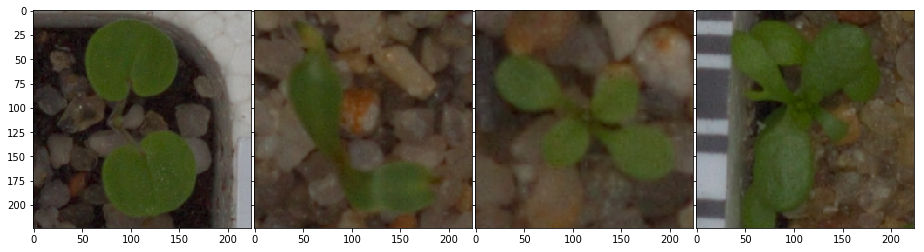

In [9]:
img, label = next(iter(valid_loader))
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    print(img.size()[0])
    ax = grid[i]
    imshow(ax, img[i])

In [10]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_batch = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                labels = labels.view(-1)
                
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                running_batch +=1

            epoch_loss = running_loss / running_batch
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
use_gpu = torch.cuda.is_available()

model = models.densenet161(pretrained=True)
# freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, len(classes))
if use_gpu:
    model = model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loaders = {'train':train_loader, 'valid':valid_loader, 'test': test_loader}

In [12]:
start_time = time.time()
model = train_model(loaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=40)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch 1/40
----------
train Loss: 1.6608 Acc: 0.4779
valid Loss: 0.8564 Acc: 0.7505
Epoch 2/40
----------
train Loss: 1.1116 Acc: 0.6518
valid Loss: 0.7450 Acc: 0.7589
Epoch 3/40
----------
train Loss: 0.9370 Acc: 0.7071
valid Loss: 0.6435 Acc: 0.7905
Epoch 4/40
----------
train Loss: 0.8326 Acc: 0.7321
valid Loss: 0.5048 Acc: 0.8495
Epoch 5/40
----------
train Loss: 0.7762 Acc: 0.7447
valid Loss: 0.5017 Acc: 0.8358
Epoch 6/40
----------
train Loss: 0.7412 Acc: 0.7487
valid Loss: 0.4319 Acc: 0.8516
Epoch 7/40
----------
train Loss: 0.7003 Acc: 0.7676
valid Loss: 0.4666 Acc: 0.8432
Epoch 8/40
----------
train Loss: 0.6012 Acc: 0.8116
valid Loss: 0.3830 Acc: 0.8863
Epoch 9/40
----------
train Loss: 0.6018 Acc: 0.7997
valid Loss: 0.3796 Acc: 0.8747
Epoch 10/40
----------
train Loss: 0.5656 Acc: 0.8253
valid Loss: 0.3851 Acc: 0.8737
Epoch 11/40
----------
train Loss: 0.6070 Acc: 0.8053
valid Loss: 0.3745 Acc: 0.8874
Epoch 12/40
----------
train Loss: 0.5964 Acc: 0.8079
valid Loss: 0.3818 A

In [13]:
path = storage_dir
torch.save(model.state_dict(), path + 'weights.torch')

In [14]:
for param in model.parameters():
    param.requires_grad = True

In [15]:
unfrz_optim = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(unfrz_optim, step_size=7, gamma=0.1)
start_time = time.time()
model = train_model(loaders, model, criterion, unfrz_optim, exp_lr_scheduler, num_epochs=40)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch 1/40
----------
train Loss: 0.4092 Acc: 0.8624
valid Loss: 0.1980 Acc: 0.9432
Epoch 2/40
----------
train Loss: 0.2987 Acc: 0.9008
valid Loss: 0.1610 Acc: 0.9484
Epoch 3/40
----------
train Loss: 0.2413 Acc: 0.9203
valid Loss: 0.1466 Acc: 0.9568
Epoch 4/40
----------
train Loss: 0.2042 Acc: 0.9324
valid Loss: 0.1240 Acc: 0.9632
Epoch 5/40
----------
train Loss: 0.1727 Acc: 0.9426
valid Loss: 0.1279 Acc: 0.9632
Epoch 6/40
----------
train Loss: 0.1595 Acc: 0.9521
valid Loss: 0.1164 Acc: 0.9716
Epoch 7/40
----------
train Loss: 0.1390 Acc: 0.9584
valid Loss: 0.1117 Acc: 0.9705
Epoch 8/40
----------
train Loss: 0.1242 Acc: 0.9616
valid Loss: 0.1061 Acc: 0.9716
Epoch 9/40
----------
train Loss: 0.1230 Acc: 0.9624
valid Loss: 0.1104 Acc: 0.9747
Epoch 10/40
----------
train Loss: 0.1216 Acc: 0.9613
valid Loss: 0.1052 Acc: 0.9737
Epoch 11/40
----------
train Loss: 0.1130 Acc: 0.9637
valid Loss: 0.1053 Acc: 0.9768
Epoch 12/40
----------
train Loss: 0.1134 Acc: 0.9655
valid Loss: 0.1073 A

Process Process-543:
Process Process-544:
Process Process-542:
Process Process-541:
Traceback (most recent call last):
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/tyler/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/tyler/anaconda3

KeyboardInterrupt: 

In [16]:
torch.save(model.state_dict(), path + 'weights2.torch')

In [17]:
model.load_state_dict(torch.load(path + 'weights2.torch'))

In [18]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d (3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d (192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm.1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [19]:
predictions = []
for i, (input, labels) in enumerate(test_loader):
    val = input.cuda()
    
    input = torch.autograd.Variable(val, volatile=True)
    output = model(input)
    prediction_matrix = func.softmax(output, dim=1).cpu().data.numpy()
    for index, pred in enumerate(prediction_matrix):
        predictions.append(pred.argmax())
    print('\r ' + str(i), end='') 
predictions


 99

[10,
 5,
 11,
 3,
 11,
 6,
 3,
 5,
 6,
 6,
 5,
 10,
 11,
 8,
 11,
 5,
 8,
 8,
 3,
 2,
 3,
 10,
 9,
 11,
 11,
 7,
 8,
 8,
 3,
 11,
 3,
 9,
 0,
 11,
 6,
 6,
 6,
 6,
 3,
 7,
 6,
 4,
 3,
 10,
 11,
 11,
 7,
 8,
 7,
 10,
 6,
 11,
 2,
 6,
 7,
 5,
 1,
 10,
 2,
 6,
 11,
 2,
 1,
 4,
 7,
 5,
 6,
 6,
 9,
 8,
 10,
 3,
 8,
 3,
 3,
 4,
 6,
 8,
 8,
 6,
 11,
 3,
 3,
 4,
 9,
 11,
 2,
 8,
 5,
 6,
 1,
 6,
 5,
 6,
 3,
 6,
 10,
 8,
 7,
 10,
 5,
 5,
 8,
 11,
 5,
 5,
 3,
 8,
 2,
 2,
 6,
 1,
 3,
 9,
 9,
 11,
 2,
 1,
 11,
 3,
 3,
 11,
 2,
 6,
 7,
 4,
 1,
 7,
 5,
 3,
 11,
 11,
 3,
 3,
 5,
 4,
 5,
 1,
 6,
 3,
 6,
 10,
 9,
 3,
 5,
 11,
 4,
 10,
 11,
 1,
 8,
 6,
 7,
 8,
 6,
 10,
 3,
 5,
 6,
 2,
 1,
 6,
 8,
 8,
 9,
 6,
 8,
 4,
 3,
 3,
 9,
 7,
 9,
 3,
 3,
 10,
 0,
 2,
 0,
 6,
 6,
 10,
 6,
 6,
 8,
 6,
 3,
 5,
 5,
 10,
 6,
 1,
 8,
 4,
 1,
 6,
 4,
 3,
 6,
 3,
 2,
 6,
 1,
 1,
 10,
 2,
 5,
 3,
 5,
 9,
 5,
 1,
 5,
 6,
 10,
 2,
 7,
 6,
 10,
 3,
 8,
 6,
 3,
 10,
 4,
 5,
 5,
 3,
 3,
 7,
 9,
 2,
 9,
 2,
 3,
 0,
 0,
 2,
 10,
 1

In [20]:
submission = sample_submission.copy()
for index, prediction in enumerate(predictions):
    submission.set_value(index, 'category_id', prediction)
    submission.set_value(index, 'category', num_to_class[prediction])
submission

,file,category,category_id
0,0021e90e4.png,Small-flowered Cranesbill,10
1,003d61042.png,Fat Hen,5
2,007b3da8b.png,Sugar beet,11
3,0086a6340.png,Common Chickweed,3
4,00c47e980.png,Sugar beet,11
5,00d090cde.png,Loose Silky-bent,6
6,00ef713a8.png,Common Chickweed,3
7,01291174f.png,Fat Hen,5
8,026716f9b.png,Loose Silky-bent,6
9,02cfeb38d.png,Loose Silky-bent,6


In [21]:
submission.drop('category_id', axis=1, inplace=True)

In [22]:
submission.columns = ['file', 'species']
submission.to_csv(result_file, sep=',', index=False)

In [23]:
%cd ~/notebooks/plant_seedling
FileLink("plant_seedling_results.csv")

/home/tyler/notebooks/plant_seedling


/home/tyler/notebooks/plant_seedling/plant_seedling_results.csv